# Correlation Clustering
Correlation clustering techniques provide the ability to cluster similar data into groups *(Bansal, Blum, and Chawla 2004)*. Unlike other clustering algorithms, such as k-means, correlation clustering does not require an initial guess for the number of clusters. Instead, it takes as input a similarity matrix, which provides a similarity measure between each pair of data points. The algorithm produces the optimal clustering based on the similarity matrix. The correlation clustering problem is known to be NP-hard.

This notebook will compare various implementations of correlation clustering. Specifically, Integer Linear Programming (ILP) formulations will be compared against weighted Max-SAT formulations *(Berg and Järvisalo 2017)*.

In [1]:
import numpy as np
import math
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

First, let's generate some clustered data points in two-dimensional space.

In [2]:
X, y = make_blobs(n_samples=100, centers=5, n_features=2, cluster_std=0.4, random_state=0)

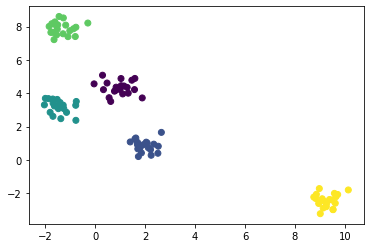

In [3]:
plt.scatter(X[:,0], X[:,1], c=y)
plt.show()

K-means clustering is fast and effective if we know the number of clusters ahead of time.

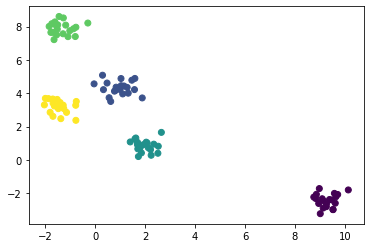

In [4]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans)
plt.show()

But what if we have no good guess for the number of clusters? This is where correlation clustering can be of help. Correlation  clustering takes an $N$ x $N$ similarity matrix $W$ as an input, where $N$ is the number of points in the data set. Each entry $w_{ij}$ is a weight representing the similarity between points $v_i$ and $v_j$. Similar points will have a positive weight. Dissimilar points will have a negative weight. The numerical value of the weight indicates the magnitude of similarity or dissimilarity. The way to calculate $W$ depends on the data. There, are several possible  methods, and examining these is beyond the scope of this project. One nice thing about correlation clustering is that it doesn't care how $W$ was created (though the quality of the results will be directly tied to how well $W$ measures similarity in the data). We will use a very simple measure of similarity based on Euclidean distance, along with a threshold value. If the distance between points is larger than the threshold, they will receive negative similarity values. Distances smaller than the threshold get positive values. The Max-SAT solvers we use later will require integer weights, so we multiply each value by some factor and round.

In [5]:
def dist(a, b):
    return np.linalg.norm(a-b)

In [6]:
mult_factor = 100
dim = X.shape[0]
alpha = 2
W = np.zeros((dim, dim))
for i in range(dim):
    for j in range(dim):
        W[i,j] = round((alpha - dist(X[i], X[j])) * mult_factor)

## Correlation Clustering Using Integer Linear Programming
The ILP formulation is described in *(Berg and Järvisalo 2017)*. We use binary variables $x_{ij} \in \{0,1\}$ for $1 \leq i < j \leq N$. Two points $v_i$ and $v_j$ are co-clustered if $x_{ij} = 1$. We set up the objective function to minimize the weight of dissimilar pairs of co-clustered points. We define a transitivity constraint $x_{ij} + x_{jk} - x_{ik} \leq 1$. This ensures that if $v_i$ and $v_j$ are co-clustered, and $v_j$ and $v_k$ are co-clustered, then $v_i$ and $v_k$ must also be co-clustered. We formulate the ILP as follows:

$$\text{minimize}~\sum_{\substack{-\infty<w_{ij}<0\\i<j}} x_{ij}|w_{ij}| - \sum_{\substack{\infty>w_{ij}>0\\i<j}} x_{ij}w_{ij}\\ \text{subject to}~x_{ij} + x_{jk} - x_{ik} \leq 1~\text{for all distinct}~i, j, k\\ x_{ij} \in \{0,1\}~\text{for all}~i, j$$

This produces $O(N^2)$ variables and $O(N^3)$ constraints.

To optimize this ILP, we will utilize two state-of-the-art LP solvers: [CPLEX](https://www.ibm.com/products/ilog-cplex-optimization-studio) and [Gurobi](https://www.gurobi.com/).

### Write LP  File
We will write the ILP to file using a [format](https://www.gurobi.com/documentation/9.0/refman/lp_format.html) that is readable by both CPLEX and Gurobi.

In [7]:
x = np.zeros(W.shape, dtype=np.int32)
bin_vars = []
var_num = 0
for i in range(dim-1):
    for j in range(i+1, dim):
        var_num += 1
        x[i,j] = var_num
        bin_vars.append('x{}'.format(var_num))

with open('files/correlation_clustering.lp', 'w') as f:
    f.write('Minimize\n')
    
    # Objective
    obj = ''
    for i in range(dim-1):
        for j in range(i+1, dim):
            if W[i,j] > 0:
                obj += ' - {} x{}'.format(int(W[i,j]), x[i,j])
            elif W[i,j] < 0:
                obj += ' + {} x{}'.format(int(-W[i,j]), x[i,j])
    f.write('  {}\n'.format(obj))
    obj = None
    

    # Constraints
    f.write('Subject To\n')
    constraint_i = 0
    for i in range(dim-2):
        for j in range(i+1, dim-1):
            for k in range(j+1, dim):
                constraint_i += 1
                f.write('  x{} + x{} - x{} <= 1\n'.format(x[i,j], x[j,k], x[i,k]))

    # Binary
    f.write('Binary\n')
    for bin_var in bin_vars:
        f.write('{}\n'.format(bin_var))
    bin_vars=None
    
    f.write('End\n')

### CPLEX
We optimize the ILP using CPLEX:

`
cplex -c "read files/correlation_clustering.lp" "optimize" "display solution variables -" > files\cplex.sol
`

The folowing code reads in the resulting solution and sorts the points into their assigned clusters.

In [8]:
cplex_out = np.zeros(var_num, dtype=np.int32)
with open('files/cplex.sol', 'r') as f:
    while True: 
        line = f.readline()
        if not line:
            break
        if line.startswith('Solution time'):
            print(line)
        if line.startswith('Variable Name'):
            break
        
    for i in range(dim-1):
        for j in range(i+1, dim):
            line = f.readline()
            if line.startswith('x'):
                var_sol = line.split()
                xi = int(var_sol[0][1:])
                xi_val = int(var_sol[1][0])
                cplex_out[xi-1] = xi_val

x = np.zeros(W.shape, dtype=np.int32)
var_i = 0
for i in range(dim-1):
    for j in range(i+1, dim):
        x[i,j] = cplex_out[var_i]
        var_i += 1


# Sort into clusters
assigned = []
for i in range(dim):
    assigned.append(False)

clusters = []
for i in range(dim-1):
    cluster = []
    for j in range(i+1, dim):
        if x[i,j] == 1:
            if not assigned[i]:
                cluster.append(X[i])
                assigned[i] = True
            if not assigned[j]:
                cluster.append(X[j])
                assigned[j] = True
    if len(cluster) > 0:
        clusters.append(cluster)

print('Found {} clusters'.format(len(clusters)))

Solution time =    0.20 sec.  Iterations = 54  Nodes = 0

Found 5 clusters


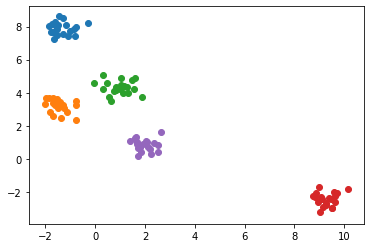

In [9]:
for cluster in clusters:
    cluster_np = np.array(cluster)
    plt.scatter(cluster_np[:,0], cluster_np[:,1])
plt.show()

Memory consumption increases rapidly as the number of data points increase. I was unable to solve problems with more than 600 points without surpassing my machine's available memory. Note that neither CPLEX nor Gurobi report their memory usage. Memory usage was estimated by manually monitoring system resources. The solvers execute very quickly on small data sets, so I was unable to obtain estimates for sizes 50 and 100.

CPLEX results for test data sets:

| Samples | Time (s) | Mem(MB) |
|---------|----------|---------|
| 50      | 0.01     | -       |
| 100     | 0.20     | -       |
| 200     | 2.39     | 302     |
| 300     | 9.36     | 1038    |
| 400     | 27.98    | 2444    |
| 500     | 65.56    | 5593    |
| 600     | 140.08   | 10699   |

### Gurobi
We optimize the ILP using Gurobi:

`
gurobi_cl ResultFile="files\gurobi.sol" "files\correlation_clustering.lp"
`

The folowing code reads in the resulting solution and sorts the points into their assigned clusters.

In [10]:
gurobi_out = np.zeros(var_num, dtype=np.int32)
with open('files/gurobi.sol', 'r') as f:
    f.readline()
        
    for i in range(dim-1):
        for j in range(i+1, dim):
            line = f.readline()
            if line.startswith('x'):
                var_sol = line.split()
                xi = int(var_sol[0][1:])
                xi_val = int(var_sol[1][0])
                cplex_out[xi-1] = xi_val

x = np.zeros(W.shape, dtype=np.int32)
var_i = 0
for i in range(dim-1):
    for j in range(i+1, dim):
        x[i,j] = cplex_out[var_i]
        var_i += 1

# Sort into clusters
assigned = []
for i in range(dim):
    assigned.append(False)

clusters = []
for i in range(dim-1):
    cluster = []
    for j in range(i+1, dim):
        if x[i,j] == 1:
            if not assigned[i]:
                cluster.append(X[i])
                assigned[i] = True
            if not assigned[j]:
                cluster.append(X[j])
                assigned[j] = True
    if len(cluster) > 0:
        clusters.append(cluster)

print('Found {} clusters'.format(len(clusters)))

Found 5 clusters


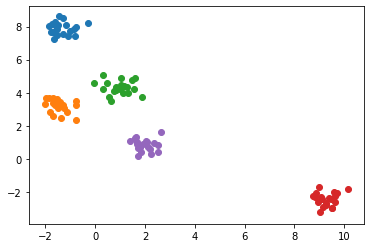

In [11]:
for cluster in clusters:
    cluster_np = np.array(cluster)
    plt.scatter(cluster_np[:,0], cluster_np[:,1])
plt.show()

Gurobi requires even more memory than CPLEX, and solve time is much higher. I was unable to solve problems with more than 500 points without surpassing my machine's available memory.

Gurobi results for test data sets:

| Samples | Time (s) | Mem (MB) |
|---------|----------|----------|
| 50      | 0.02     | -        |
| 100     | 0.42     | -        |
| 200     | 6.91     | 425      |
| 300     | 33.31    | 1480     |
| 400     | 113.38   | 3643     |
| 500     | 251.72   | 7241     |

## Correllation Clustering Using MaxSAT Encoding
The [Maximum Satisfiability](https://en.wikipedia.org/wiki/Maximum_satisfiability_problem) (MaxSAT) problem is defined as follows: given a formula written in [conjunctive normal form](https://en.wikipedia.org/wiki/Conjunctive_normal_form), find some assignment of variables that results in the maximum number of clauses evaluating to true.

An extension of this is *weighted* MaxSat, where each clause is assigned a non-negative weight. We seek to maximize the sum of the weights of satisfied clauses.

To implement correlation clustering, we utilize *partial weighted* MaxSAT. In the partial weighted MaxSAT problem, we have a set of *hard* clauses, and a set of *soft* clauses. A solution must satisfy *all* of the hard clauses. We seek to maximize the sum of the weights of all satisfied soft clauses *(Berg and Järvisalo 2017)*.

We will encode our problem as a weighted partial MaxSAT and utilize [UWrMaxSat](https://github.com/marekpiotrow/UWrMaxSat) to optimize. UWrMaxSat was a top contender in the [2019 MaxSat Evaluation](https://maxsat-evaluations.github.io/2019/).

### Helper Methods
Most MaxSat solvers take an input file in the [DIMACS](https://maxsat-evaluations.github.io/2019/rules.html#input) format. Solution output is also in this format. The folowing  method reads the output file and returns a dictionary that maps variables to their solution values (true or  false).

In [12]:
def read_solution(filename):
    """
    Read MaxSAT solution file.

    Returns:
        dict: dictionary indicating which variables are True or False.
    """
    solution = None
    with open(filename, 'r') as f:
        while True: 
            line = f.readline()  
            if not line: 
                break
            if line.startswith('c ') or line.startswith('s '):
                print(line.strip())
            if line.startswith('v '):
                solution = line.strip().split(' ', 1)[1]

    sol_arr = map(int, solution.split(' '))
    inc_dict = dict()
    for sol in sol_arr:
        if sol > 0:
            inc_dict[sol] = True
        else:
            inc_dict[-sol] = False
    
    return inc_dict

For weighted MaxSAT, solvers require that hard clauses be assigned a weight that is greater than the sum of all soft clause weights. We calculate hard clause weight below.

In [13]:
def get_hard_clause_weight(W):
    dim = W.shape[0]
    hard_cluase_weight = 0
    W_abs = np.abs(W)
    for i in range(dim-1):
        for j in range(i+1, dim):
            hard_cluase_weight += W_abs[i,j]
    return int(hard_cluase_weight + 1)

### Transitive Encoding
We must encode our clustering problem into conjunctive normal form. We will first try the *transitive* encoding *(Berg and Järvisalo 2017)*. This encoding has hard clauses analogous to the ILP transitive constraints. The soft clauses are analogous to the ILP objective function.

**Hard Clauses:**  
$(\neg x_{ij} \vee \neg x_{jk} \vee x_{ik}) \text{ for all } (v_i,v_j,v_k) \in V^3 \text{ where  } i,j,k \text{ are distinct}$

**Soft Clauses:**  
$(x_{ij}) \text{ for all similar } v_i, v_j \text{ s.t. } i<j$  
$(\neg x_{ij}) \text{ for all dissimilar } v_i, v_j \text{ s.t. } i<j$

**Soft Clause Weight:**  
$w_{ij} \text{ for all similar } v_i, v_j \text{ s.t. } i<j$  
$|w_{ij}| \text{ for all dissimilar } v_i, v_j \text{ s.t. } i<j$

This encoding produces $O(N^2)$ variables and $O(N^3)$ clauses.

In [14]:
hard_clause_weight = get_hard_clause_weight(W)

# Map variables to integers for WDIMACS format
int_map = np.zeros((dim, dim), dtype=np.int32)
var_num = 0
for i in range(dim-1):
    for j in range(i+1, dim):
        var_num += 1
        int_map[i,j] = var_num

# Hard clauses
hard_clauses = []
for i in range(dim-2):
    for j in range(i+1, dim-1):
        for k in range(j+1, dim):
            hard_clauses.append('{} -{} -{} {} 0\n'.format(hard_clause_weight, int_map[i,j], int_map[j,k], int_map[i,k]))

# Soft clauses
soft_clauses= []
for i in range(dim-1):
    for j in range(i+1, dim):
        if W[i,j] > 0:
            soft_clauses.append('{} {} 0\n'.format(int(W[i,j]), int_map[i,j]))
        elif W[i,j] < 0:
            soft_clauses.append('{} -{} 0\n'.format(int(-W[i,j]), int_map[i,j]))

with open('files/maxsat_transitive.wcnf', 'w') as f:
    f.write('c Correlation Clustering Max-SAT Transitive\n')
    f.write('c\n')
    f.write('p wcnf {} {} {}\n'.format(var_num, len(hard_clauses) + len(soft_clauses), hard_clause_weight))

    # Hard clauses
    for clause in hard_clauses:
        f.write(clause)

    # Soft clauses
    for clause in soft_clauses:
        f.write(clause)

hard_clauses = None
soft_clauses = None

We optimize the transitive encoding using UWrMaxSat:

`./uwrmaxsat <input.wcnf> -m > <outfile>`

The solution file is read.

In [15]:
inc_dict = read_solution('files/maxsat_transitive.sol')

c Parsing MaxSAT file...
c ============================[  Problem Statistics ]============================
c |  Number of variables:          4950                                         |
c |  Number of clauses:          166647 (incl.         4947 soft in queue)      |
c ===============================================================================
c Using COMiniSatPS SAT solver by Chanseok Oh (2016)
c Optimal solution: 784
c _______________________________________________________________________________
c
c restarts               : 698
c conflicts              : 2              (4 /sec)
c decisions              : 305135         (0.00 % random) (557961 /sec)
c propagations           : 4002367        (7318614 /sec)
c conflict literals      : 9              (0.00 % deleted)
c Memory used            : 21.80 MB
c CPU time               : 0.546875 s
c OptExp Enc: Srt/BDD/Add: 23 0 0
c _______________________________________________________________________________
s OPTIMUM FOUND


We sort the points into clusters in the same way we did for the ILP solutions.

In [16]:
assigned = []
for i in range(dim):
    assigned.append(False)

clusters = []
for i in range(dim-1):
    cluster = []
    for j in range(i+1, dim):
        if inc_dict[int_map[i,j]]:
            if not assigned[i]:
                cluster.append(X[i])
                assigned[i] = True
            if not assigned[j]:
                cluster.append(X[j])
                assigned[j] = True
    if len(cluster) > 0:
        clusters.append(cluster)

print('Found {} clusters'.format(len(clusters)))

Found 5 clusters


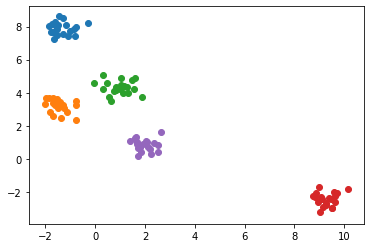

In [17]:
for cluster in clusters:
    cluster_np = np.array(cluster)
    plt.scatter(cluster_np[:,0], cluster_np[:,1])
plt.show()

Below are the results for the test data sets using the transitive encoding:

| Samples | Time (s) | Memory (MB) |
|---------|----------|-------------|
| 50      | 0.04     | 13.66       |
| 100     | 0.54     | 21.80       |
| 200     | 6.81     | 91.75       |
| 300     | 22.85    | 336.73      |
| 400     | 80.53    | 543.36      |
| 500     | 200.60   | 1059.09     |
| 600     | 379.14   | 2227.91     |
| 700     | 648.51   | 3830.15     |

### Unary Encoding
We can improve the efficiency of the algorithm by setting an upper limit on the number of clusters. We define this maximum as $K \leq N$. With this, we can formulate the *unary* encoding *(Berg and Järvisalo 2017)*. We use $N \cdot K$ variables $y_i^k$. We encode logic to ensure that $\sum_{k=1}^Ky_i^k=1$ for all $i = 1,\ldots,N$. If $y_i^k=1$ then $v_i$ is assigned to cluster $k$. The encoding  makes use of a few additional auxiliary variables. For details, refer to the referenced paper.

This encoding produces $O(E \cdot K + N \cdot K)$ variables and $O(E \cdot K)$ clauses where $E$ is the number of nonzero values in $W$. This makes it more compact than the transitive.

In [18]:
K = 8
hard_clause_weight = get_hard_clause_weight(W)

# Map variables to integers for WDIMACS format
var_num = 0

# Auxilary variables for unary encoding
y = []
for i in range(dim):
    yi =[]
    for k in range(K):
        var_num += 1
        yi.append(var_num)
    y.append(yi)

s = []
for i in range(dim):
    si = []
    for k in range(K-1):
        var_num += 1
        si.append(var_num)
    s.append(si)

A = np.zeros((dim, dim, K), dtype=np.int32)
for i in range(dim-1):
    for j in range(i+1, dim):
        for k in range(K):
            var_num += 1
            A[i,j,k] = var_num

D = np.zeros((dim, dim), dtype=np.int32)
for i in range(dim-1):
    for j in range(i+1, dim):
        var_num += 1
        D[i,j] = var_num

# Hard clauses
hard_clauses = []

# ExactlyOne(i)
for i in range(dim):
    hard_clauses.append('{} -{} {} 0\n'.format(hard_clause_weight, y[i][0], s[i][0]))
    hard_clauses.append('{} -{} -{} 0\n'.format(hard_clause_weight, y[i][K-1], s[i][K-2]))
    for k in range(1, K-1):
        hard_clauses.append('{} -{} {} 0\n'.format(hard_clause_weight, y[i][k], s[i][k]))
        hard_clauses.append('{} -{} {} 0\n'.format(hard_clause_weight, s[i][k-1], s[i][k]))
        hard_clauses.append('{} -{} -{} 0\n'.format(hard_clause_weight, y[i][k], s[i][k-1]))

for i in range(dim-1):
    for j in range(i+1, dim):
        if W[i,j] > 0:
            for k in range(K):
                # HardSimilar(i,j,k)
                hard_clauses.append('{} -{} {} 0\n'.format(hard_clause_weight, A[i,j,k], y[i][k]))
                hard_clauses.append('{} -{} {} 0\n'.format(hard_clause_weight, A[i,j,k], y[j][k]))
                hard_clauses.append('{} {} -{} -{} 0\n'.format(hard_clause_weight, A[i,j,k], y[i][k], y[j][k]))
        elif W[i,j] < 0:
            for k in range(K):
                # HardDissimilar(i,j,k)
                hard_clauses.append('{} {} -{} -{} 0\n'.format(hard_clause_weight, D[i,j], y[i][k], y[j][k]))

# Soft clauses
soft_clauses= []
for i in range(dim-1):
    for j in range(i+1, dim):
        if W[i,j] > 0:
            # SoftSimilar(i,j)
            soft_sim = '{} '.format(int(W[i,j]))
            for k in range(K):
                soft_sim += '{} '.format(A[i,j,k])
            soft_sim += '0\n'
            soft_clauses.append(soft_sim)
        elif W[i,j] < 0:
            # SoftDissimilar(i,j)
            soft_clauses.append('{} -{} 0\n'.format(int(-W[i,j]), D[i,j]))

with open('files/maxsat_unary.wcnf', 'w') as f:
    f.write('c Correlation Clustering Max-SAT Unary\n')
    f.write('c\n')
    f.write('p wcnf {} {} {}\n'.format(var_num, len(hard_clauses) + len(soft_clauses), hard_clause_weight))

    # Hard clauses
    for clause in hard_clauses:
        f.write(clause)

    # Soft clauses
    for clause in soft_clauses:
        f.write(clause)

hard_clauses = None
soft_clauses = None

In [19]:
inc_dict = read_solution('files/maxsat_unary.sol')

c Parsing MaxSAT file...
c ============================[  Problem Statistics ]============================
c |  Number of variables:         14361                                         |
c |  Number of clauses:           62363 (incl.         4947 soft in queue)      |
c ===============================================================================
c Using COMiniSatPS SAT solver by Chanseok Oh (2016)
c Optimal solution: 955
c _______________________________________________________________________________
c
c restarts               : 1028
c conflicts              : 1465           (1803 /sec)
c decisions              : 4613417        (0.00 % random) (5678052 /sec)
c propagations           : 12187663       (15000201 /sec)
c conflict literals      : 13927          (9.68 % deleted)
c Memory used            : 32.61 MB
c CPU time               : 0.8125 s
c OptExp Enc: Srt/BDD/Add: 32 0 0
c _______________________________________________________________________________
s OPTIMUM FOUND


In [20]:
y_unary = np.zeros(dim)
var_i=0
for i in range(dim):
    count = 0
    for k in range(K):
        var_i += 1
        if inc_dict[var_i] == True:
            y_unary[i] = k
            count += 1
    if count != 1:
        print('y_{} assigned {} clusters'.format(i, count))

print('Found {} clusters'.format(len(set(y_unary))))

Found 5 clusters


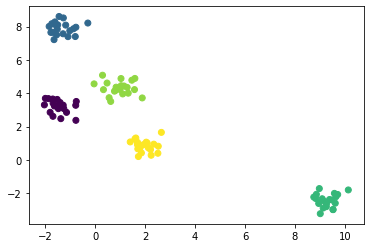

In [21]:
plt.scatter(X[:,0], X[:,1], c=y_unary)
plt.show()

Below are the results for the test data sets using the unary encoding:

| Samples | Time (s)  | Memory (MB) |
|---------|-----------|-------------|
| 50      | 0.07      | 17.12       |
| 100     | 0.81      | 32.61       |
| 200     | 6.32      | 92.16       |
| 300     | 14.12     | 187.04      |
| 400     | 69.23     | 342.77      |
| 500     | 170.45    | 513.50      |
| 600     | 265.98    | 735.01      |
| 700     | 417.42    | 924.57      |

### Binary Encoding
The *binary* encoding *(Berg and Järvisalo 2017)* is even more compact than the unary. We choose a maximum number of clusters $K = 2^a \leq N$. We define variables $b_i^k$ for $i=1,\ldots,N$ and $k=1,\ldots,a$. These variables can be interpreted as the bits in a binary integer. Combining the bits $b_i^a,\ldots,b_i^1$ gives a binary value for the cluster number to which we will assign $v_i$. Like the unary encoding, the binary encoding employs several additional auxiliary variables. See the referenced paper for a detailed description.

This encoding produces $O(E + N \cdot log_2K)$ variables and $O(E \cdot log_2K)$ clauses where $E$ is the number of nonzero values in $W$. We have managed to reduce the size of our encoding even more.

In [22]:
hard_clause_weight = get_hard_clause_weight(W)
a = 3
K = 2**a
assert(K <= dim)

var_num = 0

# Binary variables (b)
b = []
for i in range(dim):
    bi = []
    for k in range(a):
        var_num += 1
        bi.append(var_num)
    b.append(bi)

# Auxilary variables (EQ, S)
EQ = np.zeros((dim, dim, a), dtype=np.int32)
for i in range(dim-1):
    for j in range(i+1, dim):
        for k in range(a):
            var_num += 1
            EQ[i,j,k] = var_num

S = np.zeros((dim, dim), dtype=np.int32)
for i in range(dim-1):
    for j in range(i+1, dim):
        var_num += 1
        S[i,j] = var_num

# Hard clauses
hard_clauses = []
for i in range(dim-1):
    for j in range(i+1, dim):
        same_cluster_hard = '{} {} '.format(hard_clause_weight, S[i,j])
        for k in range(a):
            # Equality(i,j,k)
            hard_clauses.append('{} {} {} {} 0\n'.format(hard_clause_weight, EQ[i,j,k], b[i][k], b[j][k]))
            hard_clauses.append('{} {} -{} -{} 0\n'.format(hard_clause_weight, EQ[i,j,k], b[i][k], b[j][k]))
            hard_clauses.append('{} -{} -{} {} 0\n'.format(hard_clause_weight, EQ[i,j,k], b[i][k], b[j][k]))
            hard_clauses.append('{} -{} {} -{} 0\n'.format(hard_clause_weight, EQ[i,j,k], b[i][k], b[j][k]))

            # SameCluster(i,j)
            hard_clauses.append('{} -{} {} 0\n'.format(hard_clause_weight, S[i,j], EQ[i,j,k]))
            same_cluster_hard += '-{} '.format(EQ[i,j,k])
        same_cluster_hard += '0\n'
        hard_clauses.append(same_cluster_hard)

# Soft clauses
soft_clauses= []
for i in range(dim-1):
    for j in range(i+1, dim):
        if W[i,j] > 0:
            soft_clauses.append('{} {} 0\n'.format(int(W[i,j]), S[i,j]))
        elif W[i,j] < 0:
            soft_clauses.append('{} -{} 0\n'.format(int(-W[i,j]), S[i,j]))

# Write file
with open('files/maxsat_binary.wcnf', 'w') as f:
    f.write('c Correlation Clustering Max-SAT Binary\n')
    f.write('c\n')
    f.write('p wcnf {} {} {}\n'.format(var_num, len(hard_clauses) + len(soft_clauses), hard_clause_weight))

    # Hard clauses
    for clause in hard_clauses:
        f.write(clause)

    # Soft clauses
    for clause in soft_clauses:
        f.write(clause)

hard_clauses = None
soft_clauses = None

In [23]:
inc_dict = read_solution('files/maxsat_binary.sol')

c Parsing MaxSAT file...
c ============================[  Problem Statistics ]============================
c |  Number of variables:         20100                                         |
c |  Number of clauses:           84147 (incl.         4947 soft in queue)      |
c ===============================================================================
c Using COMiniSatPS SAT solver by Chanseok Oh (2016)
c Optimal solution: 955
c _______________________________________________________________________________
c
c restarts               : 1030
c conflicts              : 2072           (2600 /sec)
c decisions              : 273513         (0.00 % random) (343232 /sec)
c propagations           : 4580508        (5748088 /sec)
c conflict literals      : 17128          (7.28 % deleted)
c Memory used            : 33.40 MB
c CPU time               : 0.796875 s
c OptExp Enc: Srt/BDD/Add: 28 0 0
c _______________________________________________________________________________
s OPTIMUM FOUND


In [24]:
y_bin = []
var_i = 0
for i in range(dim):
    c = 0
    for k in range(a):
        var_i += 1
        if inc_dict[var_i] == True:
            c += 2**k
    y_bin.append(c + 1)
print('Found {} clusters'.format(len(set(y_bin))))

Found 5 clusters


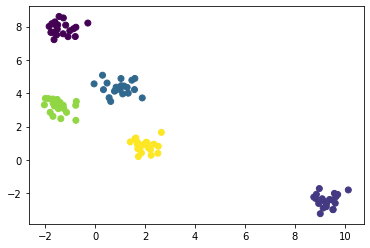

In [25]:
plt.scatter(X[:,0], X[:,1], c=y_bin)
plt.show()

Below are the results for the test data sets using the binary encoding:

| Samples | Time (s) | Memory (MB) |
|---------|----------|-------------|
| 50      | 0.12     | 16.82       |
| 100     | 0.79     | 33.40       |
| 200     | 6.06     | 95.45       |
| 300     | 12.79    | 210.08      |
| 400     | 56.67    | 318.43      |
| 500     | 121.76   | 491.46      |
| 600     | 229.31   | 729.07      |
| 700     | 375.54   | 891.93      |

## Algorithm Comparison
We compare results for each algorithm tested. The X's in the plots indicate the data set size after which I was unable to test further due to memory constraints.

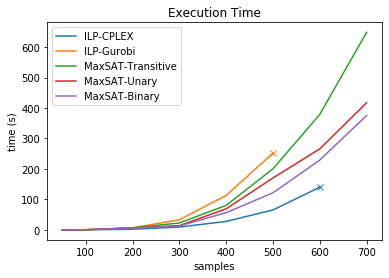

In [26]:
samples = [50,100,200,300,400,500,600,700]
cplex = [0.01,0.20,2.39,9.36,27.98,65.56,140.08,  None]
gurob = [0.02,0.42,6.91,33.31,113.38,251.72,None, None]
trans = [0.04,0.54,6.81,22.85,80.53,200.60,379.14,648.51]
unary = [0.07,0.81,6.32,14.12,69.23,170.45,265.98,417.42]
binar = [0.12,0.79,6.06,12.79,56.67,121.76,229.31,375.54]
cplex_line, = plt.plot(samples, cplex, label='ILP-CPLEX')
plt.plot(600, 140.08, marker='x', c=cplex_line.get_color())
gurob_line, = plt.plot(samples, gurob, label='ILP-Gurobi')
plt.plot(500, 251.72, marker='x', c=gurob_line.get_color())
plt.plot(samples, trans, label='MaxSAT-Transitive')
plt.plot(samples, unary, label='MaxSAT-Unary')
plt.plot(samples, binar, label='MaxSAT-Binary')
plt.xlabel('samples')
plt.ylabel('time (s)')
plt.legend()
plt.title('Execution Time')
plt.show()

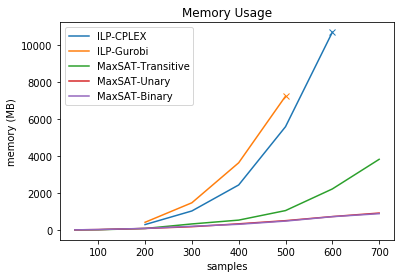

In [27]:
samples = [50,100,200,300,400,500,600,700]
cplex = [None,None,302,1038,2444,5593,10699,None]
gurob = [None,None,425,1480,3643,7241,None,None]
trans = [13.66,21.80,91.75,336.73,543.36,1059.09,2227.91,3830.15]
unary = [17.12,32.61,92.16,187.04,342.77,513.50,735.01,924.57]
binar = [16.82,33.40,95.45,210.08,318.43,491.46,729.07,891.93]
cplex_line, = plt.plot(samples, cplex, label='ILP-CPLEX')
plt.plot(600, 10699, marker='x', c=cplex_line.get_color())
gurob_line, = plt.plot(samples, gurob, label='ILP-Gurobi')
plt.plot(500, 7241, marker='x', c=gurob_line.get_color())
plt.plot(samples, trans, label='MaxSAT-Transitive')
plt.plot(samples, unary, label='MaxSAT-Unary')
plt.plot(samples, binar, label='MaxSAT-Binary')
plt.xlabel('samples')
plt.ylabel('memory (MB)')
plt.legend()
plt.title('Memory Usage')
plt.show()

As can be seen here, the MaxSat algorithms utilize far less memory than ILP. As expected, limiting the maximum number of clusters using the unary or binary MaxSat encodings significantly reduces memory usage. While ILP-CPLEX was faster for smaller data sets, memory consumption becomes prohibitive for larger data sets. The reduced memory consumption of MaxSAT algorithms allows us to solve problems on larger data sets without exhausting resources.

**References**

Bansal, Nikhil, Avrim Blum, and Shuchi Chawla. 2004. “Correlation Clustering.” *Mach. Learn.* 56 (1-3): 89–113. doi:10.1023/B:MACH.0000033116.57574.95.

Berg, Jeremias, and Matti Järvisalo. 2017. “Cost-Optimal Constrained Correlation Clustering via Weighted Partial Maximum Satisfiability.” *Artificial Intelligence* 244: 110–42. doi:10.1016/j.artint.2015.07.001.